In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import json
from datasets import load_dataset
import os

dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])


In [27]:
def get_stats(train_name):
    train_accs_all = []
    perplexities_all = []


    ckpts = sorted([
    f for f in os.listdir("ckpts/"+train_name) if os.path.isdir(os.path.join("ckpts/"+train_name, f))
    ], key=lambda x: int(x.split('-')[1]))
    # print(ckpts)

    for ckpt in ckpts:
        try:
            train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2_temp0.8.npy")==0)
            
        except:
            try:
                train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types50_seed2_temp0.8.npy")==0)
            except:
                try:
                    train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2.npy")==0)
                except:
                    try:
                        train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types50_seed2.npy")==0)
                    except:
                        train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types10_seed2_temp0.8.npy")==0)
        train_accs = train_correct.mean(axis=-1)
        train_accs_all.append(train_accs)
        
        perplexities = np.load("ckpts/"+train_name+"/"+ckpt+ "/train_perplexities.npy")
        perplexities_all.append(perplexities)
        
    if "full" not in train_name:
        subsample_idxs = np.load("ckpts/"+train_name+"/subsample_idxs.npy")
    else:
        subsample_idxs = np.arange(len(train_questions))
    
    train_accs_all = np.array(train_accs_all)[:, subsample_idxs]
    perplexities_all = np.array(perplexities_all)[:, subsample_idxs]
    
    
    
    test_accs_all = []

    for ckpt in ckpts:
        try:
            test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2.npy")==0)
        except:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2_temp0.8.npy")==0)
            except:
                try:
                    test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2_temp0.8.npy")==0)
                except:
                    test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2.npy")==0)
        test_accs_all.append(test_accs)

    test_accs_all = np.array(test_accs_all)
    
    return_dict = {}
    return_dict["train_accs_all"] = train_accs_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    
    return return_dict




def get_ratios2(stats_dict, perp_threshold=-2.5):
    train_accs_all = stats_dict["train_accs_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    
    memorization_mask = np.ones(train_accs_all.shape)*-1
    accs_all = np.ones(train_accs_all.shape)*-1
    
    for i in range(len(train_accs_all)):

        accs_all[i] =train_accs_all[i]
        
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)
    
    
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(train_accs_all))])
    
    # print(unmemorized_acc_cummax.shape)
    # print(accs_all.shape)
    unmemorized_acc_cummax = (np.min([unmemorized_acc_cummax, accs_all], axis=0))
    unmemorized_acc_cummax_mean = unmemorized_acc_cummax.mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    
    
    return_dict = {} 
    
    
    return_dict["unmemorized_acc_cummax"] = unmemorized_acc_cummax_mean
    return_dict["unmemorized_acc_cummax_all"] = unmemorized_acc_cummax

    return_dict["avg_test_acc"] = avg_test_acc
            
    return return_dict


In [54]:
stats_dict5 = get_stats("gsm8k_orig_6epochs_full_lr5e-05_bs128")
stats_dict7 = get_stats("gsm8k_orig_6epochs_full_lr5e-07_bs128")
stats_dict52 = get_stats("gsm8k_orig_6epochs_full_lr2e-05_bs128")
stats_dict4 = get_stats("gsm8k_orig_6epochs_full_lr0.0002_bs128")

stats_dict5_3 = get_stats("gsm8k_orig_3epochs_full_lr5e-05_bs128")
stats_dict52_3 = get_stats("gsm8k_orig_3epochs_shuffle1_lr2e-05_bs128")
stats_dict7_3 = get_stats("gsm8k_orig_3epochs_full_lr5e-07_bs128")
stats_dict4_3 = get_stats("gsm8k_orig_3epochs_full_lr0.0002_bs128")

stats_dict5_1 = get_stats("gsm8k_orig_1epochs_full_lr5e-05_bs128")
stats_dict7_1 = get_stats("gsm8k_orig_1epochs_full_lr5e-07_bs128")
stats_dict4_1 = get_stats("gsm8k_orig_1epochs_full_lr0.0002_bs128")

stats_dict_half = get_stats("gsm8k_orig_6epochs_half_lr2e-05_bs128")
stats_dict_quarter = get_stats("gsm8k_orig_12epochs_quarter_lr2e-05_bs128")
# stats_dict4 = get_stats("gsm8k_orig_24epochs_eighth_lr5e-05_bs128")


In [55]:
perp_threshold=-2.3

ratios_dict5 =  get_ratios2(stats_dict5, perp_threshold=perp_threshold)
ratios_dict52 =  get_ratios2(stats_dict52, perp_threshold=perp_threshold)
ratios_dict7 =  get_ratios2(stats_dict7, perp_threshold=perp_threshold)
ratios_dict4 =  get_ratios2(stats_dict4, perp_threshold=perp_threshold)

ratios_dict5_3 =  get_ratios2(stats_dict5_3, perp_threshold=perp_threshold)
ratios_dict52_3 =  get_ratios2(stats_dict52_3, perp_threshold=perp_threshold)
ratios_dict7_3 =  get_ratios2(stats_dict7_3, perp_threshold=perp_threshold)
ratios_dict4_3 =  get_ratios2(stats_dict4_3, perp_threshold=perp_threshold)

ratios_dict5_1 =  get_ratios2(stats_dict5_1, perp_threshold=perp_threshold)
ratios_dict7_1 =  get_ratios2(stats_dict7_1, perp_threshold=perp_threshold)
ratios_dict4_1 =  get_ratios2(stats_dict4_1, perp_threshold=perp_threshold)

ratios_dict_half =  get_ratios2(stats_dict_half, perp_threshold=perp_threshold)
ratios_dict_quarter =  get_ratios2(stats_dict_quarter, perp_threshold=perp_threshold)


/tmp/ipykernel_3858578/3099227383.py:25: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(ratios_dict_half["unmemorized_acc_cummax"], ratios_dict_half["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="half", linestyle="dashed", linewidth=2)
/tmp/ipykernel_3858578/3099227383.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(ratios_dict_quarter["unmemorized_acc_cummax"], ratios_dict_quarter["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="quarter", linestyle="dotted", linewidth=2)


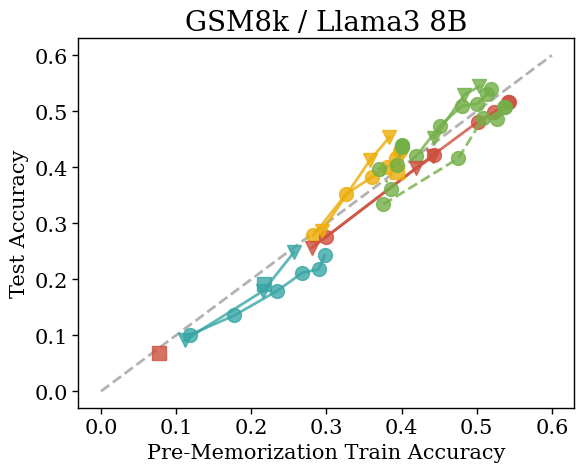

In [56]:

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'DejaVu Serif',
})

plt.plot([0, 0.6], [0, 0.6], "--", color="black", alpha=0.3, linewidth=2)


plt.plot(ratios_dict5["unmemorized_acc_cummax"], ratios_dict5["avg_test_acc"], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 6", linewidth=2)
plt.plot(ratios_dict52["unmemorized_acc_cummax"], ratios_dict52["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="lr 2e-5 epochs 6", linewidth=2)
plt.plot(ratios_dict7["unmemorized_acc_cummax"], ratios_dict7["avg_test_acc"], "o-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 6", linewidth=2)
plt.plot(ratios_dict4["unmemorized_acc_cummax"], ratios_dict4["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-4"], alpha=0.8, label="lr 2e-4 epochs 6", linewidth=2)


plt.plot(ratios_dict5_3["unmemorized_acc_cummax"], ratios_dict5_3["avg_test_acc"], "v-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 3", linewidth=2)
plt.plot(ratios_dict52_3["unmemorized_acc_cummax"], ratios_dict52_3["avg_test_acc"], "v-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="lr 2e-5 epochs 3", linewidth=2)
plt.plot(ratios_dict7_3["unmemorized_acc_cummax"], ratios_dict7_3["avg_test_acc"], "v-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 3", linewidth=2)
plt.plot(ratios_dict4_3["unmemorized_acc_cummax"], ratios_dict4_3["avg_test_acc"], "v-", markersize=10, c=color_dict["2e-4"], alpha=0.8, label="lr 2e-4 epochs 3", linewidth=2)

plt.plot(ratios_dict5_1["unmemorized_acc_cummax"], ratios_dict5_1["avg_test_acc"], "s-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 1", linewidth=2)
plt.plot(ratios_dict7_1["unmemorized_acc_cummax"], ratios_dict7_1["avg_test_acc"], "s-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 1", linewidth=2)
plt.plot(ratios_dict4_1["unmemorized_acc_cummax"], ratios_dict4_1["avg_test_acc"], "s-", markersize=10, c=color_dict["2e-4"], alpha=0.8, label="lr 2e-4 epochs 1", linewidth=2)


plt.plot(ratios_dict_half["unmemorized_acc_cummax"], ratios_dict_half["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="half", linestyle="dashed", linewidth=2)
plt.plot(ratios_dict_quarter["unmemorized_acc_cummax"], ratios_dict_quarter["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="quarter", linestyle="dotted", linewidth=2)



# plt.legend()
plt.xlabel("Pre-Memorization Train Accuracy", fontsize=15)
plt.ylabel("Test Accuracy", fontsize=15)
plt.title("GSM8k / Llama3 8B", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['right'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)
plt.tick_params(width=1, length=4)

plt.savefig("delete.png")

In [47]:
from palettable.cartocolors.qualitative import Prism_9



color_dict = {}

color_dict["2e-4"] = Prism_9.mpl_colors[2]
color_dict["5e-4"] = Prism_9.mpl_colors[3]
color_dict["2e-5"] = Prism_9.mpl_colors[4]
color_dict["5e-5"] = Prism_9.mpl_colors[5]
color_dict["5e-6"] = Prism_9.mpl_colors[6]
color_dict["5e-7"] = Prism_9.mpl_colors[7]

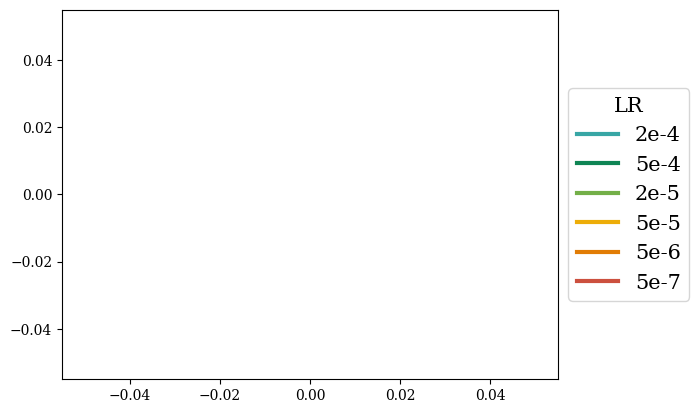

In [57]:



plt.plot([0, 0], [0, 0], c=color_dict["2e-4"], label = "2e-4", linewidth = 3)
plt.plot([0, 0], [0, 0], c=color_dict["5e-4"], label = "5e-4", linewidth = 3)
plt.plot([0, 0], [0, 0], c=color_dict["2e-5"], label = "2e-5", linewidth = 3)
plt.plot([0, 0], [0, 0], c=color_dict["5e-5"], label = "5e-5", linewidth = 3)
plt.plot([0, 0], [0, 0], c=color_dict["5e-6"], label = "5e-6", linewidth = 3)
plt.plot([0, 0], [0, 0], c=color_dict["5e-7"], label = "5e-7", linewidth = 3)

# plt.scatter([0, 0], [0, 0], c="grey", marker="o", label = "6", s=40)
# plt.scatter([0, 0], [0, 0], c="grey", marker="v", label = "3", s=40)
# plt.scatter([0, 0], [0, 0], c="grey", marker="s", label = "1", s=40)

# plt.plot([0, 0], [0, 0], c="grey", label = "Full", linewidth = 3, linestyle="solid")
# plt.plot([0, 0], [0, 0], c="grey", label = "Half", linewidth = 3, linestyle="dashed")
# plt.plot([0, 0], [0, 0], c="grey", label = "Quarter", linewidth = 3, linestyle="dotted")


# put legend on side

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, title="LR", title_fontsize="15")

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, title="Epochs", title_fontsize="15")

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, title="Dataset\nSize", title_fontsize="15")

In [50]:
from sklearn.linear_model import LinearRegression


r_squared_all =[]

for acc_threhshold in [2.5]:
    r_squared_i = []
    for perp_threshold in [-2.3, -2.4, -2.5, -2.6, -2.7]:


        ratios_dict5 = get_ratios2(stats_dict5, perp_threshold)
        ratios_dict7 = get_ratios2(stats_dict7, perp_threshold)
        ratios_dict4 = get_ratios2(stats_dict4, perp_threshold)
        
        # Example data
        x = np.concatenate([ratios_dict5["unmemorized_acc_cummax"], ratios_dict7["unmemorized_acc_cummax"], ratios_dict4["unmemorized_acc_cummax"]])
        y = np.concatenate([ratios_dict5["avg_test_acc"], ratios_dict7["avg_test_acc"], ratios_dict4["avg_test_acc"]])

        x = x.reshape(-1, 1)

        # Linear regression model
        model = LinearRegression()
        model.fit(x, y)

        # R^2 score
        r_squared = model.score(x, y)

        print(f"accuracy threshold: {acc_threhshold}")
        print(f"perplexity threshold: {perp_threshold}")
        print(f"R^2: {r_squared}")
        r_squared_i.append(r_squared)
    r_squared_all.append(r_squared_i)

accuracy threshold: 2.5
perplexity threshold: -2.3
R^2: 0.9470344598529281
accuracy threshold: 2.5
perplexity threshold: -2.4
R^2: 0.9578031337324309
accuracy threshold: 2.5
perplexity threshold: -2.5
R^2: 0.9510556259124425
accuracy threshold: 2.5
perplexity threshold: -2.6
R^2: 0.9375701668734423
accuracy threshold: 2.5
perplexity threshold: -2.7
R^2: 0.9105066077915634


In [51]:
stats_dict5 = get_stats("math_orig_6epochs_full_lr5e-05_bs24")

stats_dict7 = get_stats("math_orig_6epochs_full_lr5e-07_bs24")
stats_dict4 = get_stats("math_orig_6epochs_full_lr0.0002_bs24")

stats_dict5_3 = get_stats("math_orig_3epochs_full_lr5e-05_bs24")
stats_dict7_3 = get_stats("math_orig_3epochs_full_lr5e-07_bs24")
stats_dict4_3 = get_stats("math_orig_3epochs_full_lr0.0002_bs24")

stats_dict5_1 = get_stats("math_orig_1epochs_full_lr5e-05_bs24")
stats_dict7_1 = get_stats("math_orig_1epochs_full_lr5e-07_bs24")
stats_dict4_1 = get_stats("math_orig_1epochs_full_lr0.0002_bs24")

stats_dict_half = get_stats("math_orig_6epochs_half_lr2e-05_bs24")
stats_dict_quarter = get_stats("math_orig_12epochs_quarter_lr2e-05_bs24")
# stats_dict4 = get_stats("gsm8k_orig_24epochs_eighth_lr5e-05_bs128")


In [52]:
perp_threshold=-1.7

ratios_dict5 =  get_ratios2(stats_dict5, perp_threshold=perp_threshold)

ratios_dict7 =  get_ratios2(stats_dict7, perp_threshold=perp_threshold)
ratios_dict4 =  get_ratios2(stats_dict4, perp_threshold=perp_threshold)

ratios_dict5_3 =  get_ratios2(stats_dict5_3, perp_threshold=perp_threshold)
ratios_dict7_3 =  get_ratios2(stats_dict7_3, perp_threshold=perp_threshold)
ratios_dict4_3 =  get_ratios2(stats_dict4_3, perp_threshold=perp_threshold)

ratios_dict5_1 =  get_ratios2(stats_dict5_1, perp_threshold=perp_threshold)
ratios_dict7_1 =  get_ratios2(stats_dict7_1, perp_threshold=perp_threshold)
ratios_dict4_1 =  get_ratios2(stats_dict4_1, perp_threshold=perp_threshold)

ratios_dict_half =  get_ratios2(stats_dict_half, perp_threshold=perp_threshold)
ratios_dict_quarter =  get_ratios2(stats_dict_quarter, perp_threshold=perp_threshold)


/tmp/ipykernel_3858578/3002047857.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(ratios_dict_half["unmemorized_acc_cummax"], ratios_dict_half["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="half", linestyle="dashed", linewidth=2)
/tmp/ipykernel_3858578/3002047857.py:20: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(ratios_dict_quarter["unmemorized_acc_cummax"], ratios_dict_quarter["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="quarter", linestyle="dotted", linewidth=2)


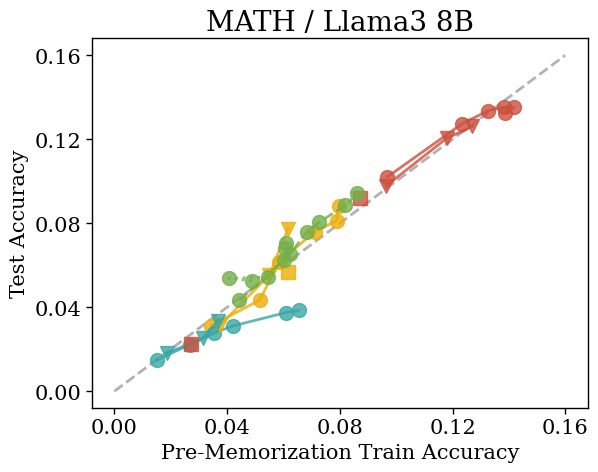

In [53]:


plt.plot([0, 0.16], [0, 0.16], "--", color="black", alpha=0.3, linewidth=2)


plt.plot(ratios_dict5["unmemorized_acc_cummax"], ratios_dict5["avg_test_acc"], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 6", linewidth=2)

plt.plot(ratios_dict7["unmemorized_acc_cummax"], ratios_dict7["avg_test_acc"], "o-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 6", linewidth=2)
plt.plot(ratios_dict4["unmemorized_acc_cummax"], ratios_dict4["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-4"], alpha=0.8, label="lr 2e-4 epochs 6", linewidth=2)


plt.plot(ratios_dict5_3["unmemorized_acc_cummax"], ratios_dict5_3["avg_test_acc"], "v-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 3", linewidth=2)
plt.plot(ratios_dict7_3["unmemorized_acc_cummax"], ratios_dict7_3["avg_test_acc"], "v-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 3", linewidth=2)
plt.plot(ratios_dict4_3["unmemorized_acc_cummax"], ratios_dict4_3["avg_test_acc"], "v-", markersize=10, c=color_dict["2e-4"], alpha=0.8, label="lr 2e-4 epochs 3", linewidth=2)

plt.plot(ratios_dict5_1["unmemorized_acc_cummax"], ratios_dict5_1["avg_test_acc"], "s-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 1", linewidth=2)
plt.plot(ratios_dict7_1["unmemorized_acc_cummax"], ratios_dict7_1["avg_test_acc"], "s-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 1", linewidth=2)
plt.plot(ratios_dict4_1["unmemorized_acc_cummax"], ratios_dict4_1["avg_test_acc"], "s-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 2e-4 epochs 1", linewidth=2)


plt.plot(ratios_dict_half["unmemorized_acc_cummax"], ratios_dict_half["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="half", linestyle="dashed", linewidth=2)
plt.plot(ratios_dict_quarter["unmemorized_acc_cummax"], ratios_dict_quarter["avg_test_acc"], "o-", markersize=10, c=color_dict["2e-5"], alpha=0.8, label="quarter", linestyle="dotted", linewidth=2)



# plt.legend()
plt.xlabel("Pre-Memorization Train Accuracy", fontsize=15)
plt.ylabel("Test Accuracy", fontsize=15)
plt.title("MATH / Llama3 8B", fontsize=20)
plt.yticks([0, 0.04, 0.08, 0.12, 0.16], fontsize=15)
plt.xticks([0, 0.04, 0.08, 0.12, 0.16],fontsize=15)

plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['right'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)
plt.tick_params(width=1, length=4)

plt.savefig("delete.png")







# plt.plot([0, 0.15], [0, 0.15], "--", color="black", alpha=0.5)


# plt.plot(ratios_dict5["unmemorized_acc_cummax"], ratios_dict5["avg_test_acc"], "o-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 6")
# plt.plot(ratios_dict7["unmemorized_acc_cummax"], ratios_dict7["avg_test_acc"], "o-", markersize=10, c="C1", alpha=0.8, label="lr 5e-7 epochs 6")
# plt.plot(ratios_dict4["unmemorized_acc_cummax"], ratios_dict4["avg_test_acc"], "o-", markersize=10, c="C2", alpha=0.8, label="lr 2e-4 epochs 6")


# plt.plot(ratios_dict5_3["unmemorized_acc_cummax"], ratios_dict5_3["avg_test_acc"], "v-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 3")
# plt.plot(ratios_dict7_3["unmemorized_acc_cummax"], ratios_dict7_3["avg_test_acc"], "v-", markersize=10, c="C1", alpha=0.8, label="lr 5e-7 epochs 3")
# plt.plot(ratios_dict4_3["unmemorized_acc_cummax"], ratios_dict4_3["avg_test_acc"], "v-", markersize=10, c="C2", alpha=0.8, label="lr 2e-4 epochs 3")

# plt.plot(ratios_dict5_1["unmemorized_acc_cummax"], ratios_dict5_1["avg_test_acc"], "s-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 1")
# plt.plot(ratios_dict7_1["unmemorized_acc_cummax"], ratios_dict7_1["avg_test_acc"], "s-", markersize=10, c="C1", alpha=0.8, label="lr 5e-7 epochs 1")
# plt.plot(ratios_dict4_1["unmemorized_acc_cummax"], ratios_dict4_1["avg_test_acc"], "s-", markersize=10, c="C2", alpha=0.8, label="lr 2e-4 epochs 1")


# plt.plot(ratios_dict_half["unmemorized_acc_cummax"], ratios_dict_half["avg_test_acc"], "o-", markersize=10, c="C3", alpha=0.8, label="half")
# plt.plot(ratios_dict_quarter["unmemorized_acc_cummax"], ratios_dict_quarter["avg_test_acc"], "o-", markersize=10, c="C4", alpha=0.8, label="quarter")



# plt.legend()
# plt.xlabel("Pre-Memorization Train Accuracy")
# plt.ylabel("Test Accuracy")
# plt.title("MATH Llama3 8B")
# plt.savefig("delete.png")

/tmp/ipykernel_3858578/2833177681.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([0.438, 0.479, 0.512, 0.544, 0.561, 0.572], [0.434, 0.478, 0.503, 0.534, 0.559, 0.569], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="half", linestyle="dashed", linewidth=2)
/tmp/ipykernel_3858578/2833177681.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([0.332, 0.388, 0.389, 0.403, 0.435, 0.441, 0.471, 0.483, 0.495, 0.499, 0.505, 0.507], [0.345, 0.377, 0.396, 0.425, 0.442, 0.456, 0.468, 0.479, 0.488, 0.505, 0.502, 0.491], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="quarter", linestyle="dotted", linewidth=2)


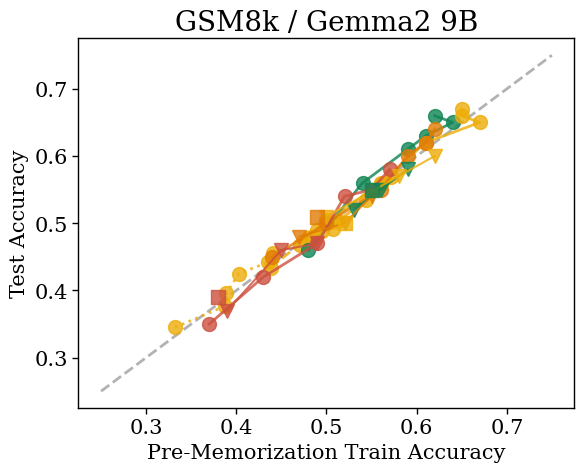

In [49]:

# plt.plot([0.35, 0.7], [0.35, 0.7])

plt.plot([0.25, 0.75],  [0.25, 0.75], "--", color="black", alpha=0.3, linewidth=2)

plt.plot([0.438, 0.479, 0.512, 0.544, 0.561, 0.572], [0.434, 0.478, 0.503, 0.534, 0.559, 0.569], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="half", linestyle="dashed", linewidth=2)
plt.plot([0.332, 0.388, 0.389, 0.403, 0.435, 0.441, 0.471, 0.483, 0.495, 0.499, 0.505, 0.507], [0.345, 0.377, 0.396, 0.425, 0.442, 0.456, 0.468, 0.479, 0.488, 0.505, 0.502, 0.491], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="quarter", linestyle="dotted", linewidth=2)


plt.plot([0.48, 0.54, 0.59, 0.61, 0.64, 0.62], [0.46, 0.56, 0.61, 0.63, 0.65, 0.66], "o-", markersize=10, c=color_dict["5e-4"], alpha=0.8, label="lr 5e-4 epochs 6", linewidth=2)
plt.plot([0.49, 0.56, 0.61, 0.67, 0.65, 0.65], [0.49, 0.56, 0.62, 0.65, 0.66, 0.67], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 6", linewidth=2)
plt.plot([0.44, 0.50, 0.56, 0.59, 0.61, 0.62], [0.45, 0.50, 0.55, 0.60, 0.62, 0.64], "o-", markersize=10, c=color_dict["5e-6"], alpha=0.8, label="lr 5e-6 epochs 6", linewidth=2)
plt.plot([0.37, 0.43, 0.49, 0.52, 0.55, 0.57], [0.35, 0.42, 0.47, 0.54, 0.55, 0.58], "o-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 6", linewidth=2)


plt.plot([0.53, 0.56, 0.59], [0.52, 0.55, 0.58], "v-", markersize=10, c=color_dict["5e-4"], alpha=0.8, label="lr 5e-4 epochs 3")
plt.plot([0.50, 0.58, 0.62], [0.51, 0.57, 0.60] , "v-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 3")
plt.plot([0.47, 0.52, 0.55], [0.48, 0.50, 0.54], "v-", markersize=10, c=color_dict["5e-6"], alpha=0.8, label="lr 5e-6 epochs 3")
plt.plot([0.39, 0.45, 0.49], [0.37, 0.46, 0.47], "v-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 3")



plt.plot([0.55], [0.55], "s-", markersize=10, c=color_dict["5e-4"], alpha=0.8, label="lr 5e-4 epochs 1")
plt.plot([0.52], [0.50], "s-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 1")
plt.plot([0.49], [0.51], "s-", markersize=10, c=color_dict["5e-6"], alpha=0.8, label="lr 5e-6 epochs 1")
plt.plot([0.38], [0.39], "s-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 1")


# plt.plot(ratios_dict_half["unmemorized_acc_cummax"], ratios_dict_half["avg_test_acc"], "o-", markersize=10, c="C2", alpha=0.8, label="half", linestyle="dashed", linewidth=2)
# plt.plot(ratios_dict_quarter["unmemorized_acc_cummax"], ratios_dict_quarter["avg_test_acc"], "o-", markersize=10, c="C2", alpha=0.8, label="quarter", linestyle="dashed", linewidth=2)


# plt.legend()
plt.xlabel("Pre-Memorization Train Accuracy", fontsize=15)
plt.ylabel("Test Accuracy", fontsize=15)
plt.title("GSM8k / Gemma2 9B", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['right'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)
plt.tick_params(width=1, length=4)






/tmp/ipykernel_3858578/73957080.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([0.152, 0.179, 0.185, 0.217, 0.239, 0.264], [0.131, 0.168, 0.202, 0.231, 0.244, 0.240], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="half", linestyle="dashed", linewidth=2)
/tmp/ipykernel_3858578/73957080.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([0.050, 0.083, 0.088, 0.092, 0.092, 0.123, 0.128, 0.131, 0.136, 0.138, 0.139, 0.139], [0.080, 0.115, 0.149, 0.160, 0.173, 0.187, 0.194, 0.197, 0.186, 0.194, 0.179, 0.168], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="quarter", linestyle="dotted", linewidth=2)


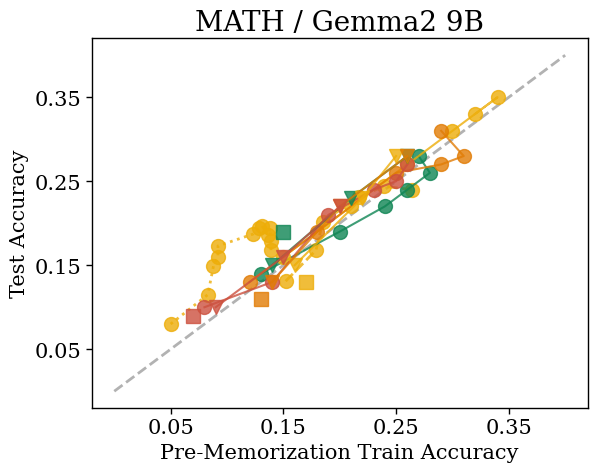

In [48]:
plt.plot([0, 0.4],  [0, 0.4], "--", color="black", alpha=0.3, linewidth=2)


plt.plot([0.152, 0.179, 0.185, 0.217, 0.239, 0.264], [0.131, 0.168, 0.202, 0.231, 0.244, 0.240], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="half", linestyle="dashed", linewidth=2)
plt.plot([0.050, 0.083, 0.088, 0.092, 0.092, 0.123, 0.128, 0.131, 0.136, 0.138, 0.139, 0.139], [0.080, 0.115, 0.149, 0.160, 0.173, 0.187, 0.194, 0.197, 0.186, 0.194, 0.179, 0.168], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="quarter", linestyle="dotted", linewidth=2)


plt.plot([0.13, 0.20, 0.24, 0.26, 0.28, 0.27], [0.14, 0.19, 0.22, 0.24, 0.26, 0.28], "o-", markersize=10, c=color_dict["5e-4"], alpha=0.8, label="lr 5e-4 epochs 6")
plt.plot([0.15, 0.21, 0.26, 0.30, 0.34, 0.32], [0.16, 0.22, 0.27, 0.31, 0.35, 0.33], "o-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 6")
plt.plot([0.12, 0.18, 0.25, 0.29, 0.31, 0.29], [0.13, 0.19, 0.26, 0.27, 0.28, 0.31], "o-", markersize=10, c=color_dict["5e-6"], alpha=0.8, label="lr 5e-6 epochs 6")
plt.plot([0.08, 0.14, 0.19, 0.23, 0.25, 0.26], [0.10, 0.13, 0.21, 0.24, 0.25, 0.27], "o-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 6")


plt.plot([0.14, 0.21, 0.26], [0.15, 0.23, 0.28], "v-", markersize=10, c=color_dict["5e-4"], alpha=0.8, label="lr 5e-4 epochs 3")
plt.plot([0.16, 0.22, 0.25], [0.15, 0.23, 0.28] , "v-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 3")
plt.plot([0.14, 0.20, 0.26], [0.13, 0.22, 0.28], "v-", markersize=10, c=color_dict["5e-6"], alpha=0.8, label="lr 5e-6 epochs 3")
plt.plot([0.09, 0.15, 0.20], [0.10, 0.16, 0.22], "v-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 3")



plt.plot([0.15], [0.19], "s-", markersize=10, c=color_dict["5e-4"], alpha=0.8, label="lr 5e-4 epochs 1")
plt.plot([0.17], [0.13], "s-", markersize=10, c=color_dict["5e-5"], alpha=0.8, label="lr 5e-5 epochs 1")
plt.plot([0.13], [0.11], "s-", markersize=10, c=color_dict["5e-6"], alpha=0.8, label="lr 5e-6 epochs 1")
plt.plot([0.07], [0.09], "s-", markersize=10, c=color_dict["5e-7"], alpha=0.8, label="lr 5e-7 epochs 1")

plt.xlabel("Pre-Memorization Train Accuracy", fontsize=15)
plt.ylabel("Test Accuracy", fontsize=15)
plt.title("MATH / Gemma2 9B", fontsize=20)
plt.yticks([0.05, 0.15, 0.25, 0.35,], fontsize=15)
plt.xticks([0.05, 0.15, 0.25, 0.35,],fontsize=15)

plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['right'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)
plt.tick_params(width=1, length=4)